##### Import

In [1]:
import warnings
import papermill as pm
import scrapbook as sb
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
from tqdm import tqdm
import shap
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
# from sklearn.linear_model import LinearRegression, Ridge, Lasso
# from sklearn.pipeline import Pipeline
import os
import gc
import sys

# Filter out warning messages
warnings.filterwarnings('ignore')

# Set pandas display options
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

# Set seaborn style
sns.set_style('whitegrid')

# Add the parent directory to sys.path
sys.path.insert(1, os.path.join(sys.path[0], '..'))

# Index and deciles for data slicing
idx = pd.IndexSlice

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
# from pathlib import Path
# import pandas as pd
# from utils import rank_stocks_and_quantile
# # UNSEEN_KEY = '/data/YEAR_20220803_20230803'
# top = 250  # parameters -> papermill
# DATA_STORE = Path(f'data/{top}_dataset.h5')
# with pd.HDFStore(DATA_STORE) as store:
#     # unseen = store[UNSEEN_KEY]
#     print(store.keys())

In [3]:
from utils import rank_stocks_and_quantile

top = 250 # parameters -> papermill

DATA_STORE = Path(f'data/{top}_dataset.h5')
dataset_key = '/data/YEAR_20200930_20220802'
# dataset_key = None
target = 'TARGET_ret_fwd_frac_order'
with pd.HDFStore(DATA_STORE) as store:
    dataset = store[dataset_key]
    # dataset = store['/data/YEAR_20161115_20181022']
    dataset = rank_stocks_and_quantile(dataset, TARGET_col=target)

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 117250 entries, (Timestamp('2020-09-30 00:00:00+0000', tz='UTC'), 'AA') to (Timestamp('2022-08-02 00:00:00+0000', tz='UTC'), 'ZTS')
Columns: 600 entries, FEATURE_open to TARGET_ret_fwd_frac_order_rank_quantiled
dtypes: float32(360), float64(32), int32(198), int64(1), int8(9)
memory usage: 280.6+ MB


In [5]:
# Define the features and label columns
features = [col for col in dataset.columns if col.startswith('FEATURE_')]
label = f'{target}_rank_quantiled'

# Print the number of features and the label
print(f"Number of features: {len(features)}")
print(f"Label: {label}")

# Remove timezone information from the date index
dataset.index.set_levels(dataset.index.levels[0].tz_localize(None), level=0, inplace=True)

### Since we have unseen dataset
# # Get unique dates and sort them
# unique_dates = dataset.index.get_level_values('date').unique().sort_values()

# # Define the look-ahead gap
# look_ahead = 1

# # Split dates for training and testing with a gap
# train_dates = unique_dates[:-21-look_ahead]
# test_dates = unique_dates[-21:]

# # Split the dataset using the train and test dates
# train_data = dataset[dataset.index.get_level_values('date').isin(train_dates)]
# test_data = dataset[dataset.index.get_level_values('date').isin(test_dates)]


Number of features: 586
Label: TARGET_ret_fwd_frac_order_rank_quantiled


In [6]:
def get_fi(model):
    fi = model.feature_importance(importance_type='gain')
    return pd.Series(fi / fi.sum(), index=model.feature_name())

def ic_lgbm(preds, train_data):
    """Custom IC eval metric for lightgbm"""
    return 'ic', spearmanr(preds, train_data.get_label())[0], True

def sharpe_ratio_lgbm(preds, train_data):
    """Custom Sharpe ratio eval metric for lightgbm."""
    labels = train_data.get_label()
    if not isinstance(train_data.data.index, pd.MultiIndex):
        raise ValueError("Expecting a MultiIndex with date as the first level")

    grouped_labels = pd.Series(labels, index=train_data.data.index).groupby(level=0)
    grouped_preds = pd.Series(preds, index=train_data.data.index).groupby(level=0)

    daily_scores = []
    for (_, actuals_for_day), (_, preds_for_day) in zip(grouped_labels, grouped_preds):
        score_for_day = spearmanr(actuals_for_day, preds_for_day)[0]
        daily_scores.append(score_for_day if not np.isnan(score_for_day) else 0)

    sharpe_ratio = np.mean(daily_scores) / (np.std(daily_scores) + 1e-9)
    return 'sharpe_ratio', sharpe_ratio, True

def custom_eval_metrics(preds, train_data):
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
    labels = train_data.get_label()
    mae = mean_absolute_error(labels, preds)
    mse = mean_squared_error(labels, preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(labels, preds)
    return [('MAE', mae, False), 
            ('MSE', mse, False), 
            ('RMSE', rmse, False), 
            ('R2', r2, True)]

def combined_eval_metrics(preds, train_data):
    ic_result = ic_lgbm(preds, train_data)
    sharpe_ratio_result = sharpe_ratio_lgbm(preds, train_data)
    custom_metrics_results = custom_eval_metrics(preds, train_data)
    return [ic_result, sharpe_ratio_result] + custom_metrics_results

In [7]:
def metrics_on_fold(era_scores, weights=None):
    era_scores = pd.Series(era_scores)
    
    # Calculate metrics
    mean_correlation = np.mean(era_scores)
    std_deviation = np.std(era_scores)
    sharpe_ratio = mean_correlation / std_deviation
    max_dd = (era_scores.cummax() - era_scores).max()

    # Smart Sharpe
    smart_sharpe = mean_correlation \
        / (std_deviation + np.std(era_scores.diff()))
    
    # Autocorrelation
    autocorrelation = era_scores.autocorr()

    metrics = pd.Series({
        'mean_correlation': mean_correlation,
        'std_deviation': std_deviation,
        'sharpe_ratio': sharpe_ratio,
        'smart_sharpe': smart_sharpe,
        'autocorrelation': autocorrelation,
        'max_dd': max_dd,
        'min_correlation': era_scores.min(),
        'max_correlation': era_scores.max(),
    })

    if weights:
        normalized_metrics = (metrics - metrics.min()) / (metrics.max() - metrics.min())
        weighted_values = normalized_metrics.multiply(pd.Series(weights))
        metrics["weighted_score"] = weighted_values.sum()

    _ = gc.collect()

    return metrics

In [8]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import optuna
import mlflow
import mlflow.lightgbm
from optuna.integration import LightGBMPruningCallback
from scipy.stats import spearmanr
from utils import CustomBackwardMultipleTimeSeriesCV
import warnings

warnings.filterwarnings('ignore')

evals_result = {}

def get_categoricals(dataset, threshold):
    return [col for col in dataset.columns if \
            dataset[col].nunique() < threshold and \
            dataset[col].ge(0).all() and col.startswith("FEATURE_")]

def objective(trial, data, features, cv):
    # Dynamic categoricals based on the trial's suggested threshold
    cat_threshold = trial.suggest_int('cat_threshold', 5, 50)
    categoricals = [col for col in data.columns if data[col].nunique() < cat_threshold 
                    and data[col].ge(0).all() and col.startswith("FEATURE_")]

    params = {
        'boosting': 'gbdt',
        'objective': 'regression',
        'verbose': -1,
        'metric': 'None',
        'device': 'gpu',
        'num_leaves': trial.suggest_int('num_leaves', 30, 150),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
    }

    early_stopping = lgb.early_stopping(stopping_rounds=500, \
        verbose=True, first_metric_only=True)
    daily_scores_in_fold = []

    for train_idx, val_idx in cv:
        train_features = data.loc[train_idx, features]
        train_labels = data.loc[train_idx, label]
        lgb_train = lgb.Dataset(data=train_features, label=train_labels, 
                        categorical_feature=categoricals, free_raw_data=False)

        val_features = data.loc[val_idx, features]
        val_labels = data.loc[val_idx, label]
        lgb_val = lgb.Dataset(data=val_features, label=val_labels, 
                categorical_feature=categoricals, free_raw_data=False)

        model = lgb.train(params=params,
                  train_set=lgb_train,
                  num_boost_round=5000,
                  valid_sets=[lgb_train, lgb_val],
                  valid_names=['train', 'valid_0'],
                  feval=combined_eval_metrics,   # Updated feval
                  callbacks=[lgb.record_evaluation(evals_result),
                             early_stopping,
                             LightGBMPruningCallback(trial, 'sharpe_ratio')])

        daily_scores_in_fold.extend(evals_result['valid_0']['sharpe_ratio'])

    weights = {
        'sharpe_ratio': 0.95,       # Primary objective, so highest weight
        'max_dd': -0.1,             # Major risk metric, negative to penalize higher drawdowns
        'autocorrelation': -0.1,    # Penalize strategies showing signs of overfitting
        # 'std_deviation': -0.025,    # Mild penalty for higher volatility 
        # 'smart_sharpe': 0.075       # Supplementary to Sharpe Ratio but considering autocorrelation
    }


    metrics = metrics_on_fold(daily_scores_in_fold, weights=weights)
    # score = metrics['sharpe_ratio']
    score = metrics["weighted_score"]
    # Log parameters, metrics, and evaluation results to MLflow
    with mlflow.start_run():
        mlflow.log_params(params)
        
        # Log metrics from metrics dictionary
        mlflow.log_metrics(metrics)
        
        # Logging each score and metric in evals_result
        for valid_set, metrics_dict in evals_result.items():
            for metric, values in metrics_dict.items():
                for idx, value in enumerate(values):
                    metric_name = f"{valid_set}_{metric}_{idx}"
                    mlflow.log_metric(metric_name, value)

        # Log the average sharpe ratio
        mlflow.log_metric("avg_score_across_folds", score)

        # mlflow.lightgbm.log_model(model, "lightgbm_model")

    # score = metrics['sharpe_ratio']
    # print(score)
    return score if not np.isnan(score) else 1e-9

In [9]:
import os
import optuna

cv = CustomBackwardMultipleTimeSeriesCV(dataset, train_period_length=142, 
                                        test_period_length=21, 
                                        lookahead=1, 
                                        date_idx='date')

def progress_bar(study, trial, n_trials):
    progress = (trial.number + 1) / n_trials
    best_trial_msg = ""
    if study.best_trial is not None:
        best_trial_msg = f"Best is trial {study.best_trial.number} \
            with value: {study.best_trial.value}."
    print(f'Trial {trial.number + 1}/{n_trials} finished with value: \
        {trial.value} and parameters: {trial.params}. {best_trial_msg}')

# Check if 'study' directory exists, if not, create it.
if not os.path.exists("study"):
    os.makedirs("study")

# Use SQLite to store optimization results.
# The study results are stored in the "study" folder as "study.db".
storage_name = "sqlite:///study/study.db"

# Name of the study. This should be consistent for resuming the study later.
study_name = "lgbm_optimization"

# Try to load the study. If it doesn't exist, create a new one.
study = optuna.create_study(study_name=study_name,
                            storage=storage_name,
                            direction='maximize',
                            load_if_exists=True, 
                            pruner=optuna.pruners.MedianPruner(n_startup_trials=10, \
                            n_warmup_steps=5))

n_trials = 5
study.optimize(lambda trial: objective(trial, dataset, features, cv), 
               n_trials=n_trials, 
               callbacks=[lambda study, trial: progress_bar(study, trial, n_trials)])

# Printing the optimization results
print(f'Best trial score: {study.best_trial.value}')
print('Best hyperparameters:')
for key, value in study.best_trial.params.items():
    print(f'{key}: {value}')

best_params = study.best_params
print("Best parameters found by Optuna:")
print(best_params)

# Remove the study database
os.remove("study/study.db")
print("Database has been deleted.")

[I 2023-10-02 22:57:34,974] A new study created in RDB with name: lgbm_optimization


Training until validation scores don't improve for 500 rounds
Early stopping, best iteration is:
[56]	train's ic: 0.93723	train's sharpe_ratio: 25.2737	train's MAE: 0.0897244	train's MSE: 0.0153113	train's RMSE: 0.123739	train's R2: 0.877713	valid_0's ic: 0.957547	valid_0's sharpe_ratio: 76.6077	valid_0's MAE: 0.0820579	valid_0's MSE: 0.0121671	valid_0's RMSE: 0.110305	valid_0's R2: 0.903045
Evaluated only: ic
Training until validation scores don't improve for 500 rounds
Early stopping, best iteration is:
[32]	train's ic: 0.967402	train's sharpe_ratio: 135.77	train's MAE: 0.083947	train's MSE: 0.0103643	train's RMSE: 0.101805	train's R2: 0.917151	valid_0's ic: 0.965166	valid_0's sharpe_ratio: 166.56	valid_0's MAE: 0.0909253	valid_0's MSE: 0.0123429	valid_0's RMSE: 0.111098	valid_0's R2: 0.901254
Evaluated only: ic


[I 2023-10-02 22:59:21,228] Trial 0 finished with value: 0.0013443128504290972 and parameters: {'cat_threshold': 43, 'num_leaves': 117, 'learning_rate': 0.054907921121287194, 'feature_fraction': 0.8077450246990532, 'bagging_fraction': 0.5854978396496205, 'bagging_freq': 6, 'min_child_samples': 89, 'lambda_l1': 1.2178709068783142e-07, 'lambda_l2': 1.4663559874253829e-05}. Best is trial 0 with value: 0.0013443128504290972.


Trial 1/5 finished with value:         0.0013443128504290972 and parameters: {'cat_threshold': 43, 'num_leaves': 117, 'learning_rate': 0.054907921121287194, 'feature_fraction': 0.8077450246990532, 'bagging_fraction': 0.5854978396496205, 'bagging_freq': 6, 'min_child_samples': 89, 'lambda_l1': 1.2178709068783142e-07, 'lambda_l2': 1.4663559874253829e-05}. Best is trial 0             with value: 0.0013443128504290972.


[I 2023-10-02 22:59:25,152] Trial 1 finished with value: 0.0 and parameters: {'cat_threshold': 50, 'num_leaves': 91, 'learning_rate': 0.09787540459123958, 'feature_fraction': 0.5179482642617796, 'bagging_fraction': 0.44823717011011455, 'bagging_freq': 1, 'min_child_samples': 46, 'lambda_l1': 7.543195918890414, 'lambda_l2': 1.0604198228671808e-05}. Best is trial 0 with value: 0.0013443128504290972.


Trial 2/5 finished with value:         0.0 and parameters: {'cat_threshold': 50, 'num_leaves': 91, 'learning_rate': 0.09787540459123958, 'feature_fraction': 0.5179482642617796, 'bagging_fraction': 0.44823717011011455, 'bagging_freq': 1, 'min_child_samples': 46, 'lambda_l1': 7.543195918890414, 'lambda_l2': 1.0604198228671808e-05}. Best is trial 0             with value: 0.0013443128504290972.


[I 2023-10-02 22:59:29,039] Trial 2 finished with value: 0.0 and parameters: {'cat_threshold': 43, 'num_leaves': 68, 'learning_rate': 0.007931146419999733, 'feature_fraction': 0.7294239178205196, 'bagging_fraction': 0.5649787864888463, 'bagging_freq': 5, 'min_child_samples': 57, 'lambda_l1': 0.2875840272700774, 'lambda_l2': 0.008700828462370377}. Best is trial 0 with value: 0.0013443128504290972.


Trial 3/5 finished with value:         0.0 and parameters: {'cat_threshold': 43, 'num_leaves': 68, 'learning_rate': 0.007931146419999733, 'feature_fraction': 0.7294239178205196, 'bagging_fraction': 0.5649787864888463, 'bagging_freq': 5, 'min_child_samples': 57, 'lambda_l1': 0.2875840272700774, 'lambda_l2': 0.008700828462370377}. Best is trial 0             with value: 0.0013443128504290972.


[I 2023-10-02 22:59:33,079] Trial 3 finished with value: 0.0 and parameters: {'cat_threshold': 17, 'num_leaves': 57, 'learning_rate': 0.02082565136791167, 'feature_fraction': 0.7618252958073393, 'bagging_fraction': 0.560339859268029, 'bagging_freq': 3, 'min_child_samples': 89, 'lambda_l1': 0.00027539853221662596, 'lambda_l2': 0.08463854698276671}. Best is trial 0 with value: 0.0013443128504290972.


Trial 4/5 finished with value:         0.0 and parameters: {'cat_threshold': 17, 'num_leaves': 57, 'learning_rate': 0.02082565136791167, 'feature_fraction': 0.7618252958073393, 'bagging_fraction': 0.560339859268029, 'bagging_freq': 3, 'min_child_samples': 89, 'lambda_l1': 0.00027539853221662596, 'lambda_l2': 0.08463854698276671}. Best is trial 0             with value: 0.0013443128504290972.


[I 2023-10-02 22:59:37,022] Trial 4 finished with value: 0.0 and parameters: {'cat_threshold': 22, 'num_leaves': 30, 'learning_rate': 0.040437838887183546, 'feature_fraction': 0.5591492254989354, 'bagging_fraction': 0.7644642505480792, 'bagging_freq': 2, 'min_child_samples': 12, 'lambda_l1': 4.826297779491741e-08, 'lambda_l2': 0.05868938036156914}. Best is trial 0 with value: 0.0013443128504290972.


Trial 5/5 finished with value:         0.0 and parameters: {'cat_threshold': 22, 'num_leaves': 30, 'learning_rate': 0.040437838887183546, 'feature_fraction': 0.5591492254989354, 'bagging_fraction': 0.7644642505480792, 'bagging_freq': 2, 'min_child_samples': 12, 'lambda_l1': 4.826297779491741e-08, 'lambda_l2': 0.05868938036156914}. Best is trial 0             with value: 0.0013443128504290972.
Best trial score: 0.0013443128504290972
Best hyperparameters:
cat_threshold: 43
num_leaves: 117
learning_rate: 0.054907921121287194
feature_fraction: 0.8077450246990532
bagging_fraction: 0.5854978396496205
bagging_freq: 6
min_child_samples: 89
lambda_l1: 1.2178709068783142e-07
lambda_l2: 1.4663559874253829e-05
Best parameters found by Optuna:
{'cat_threshold': 43, 'num_leaves': 117, 'learning_rate': 0.054907921121287194, 'feature_fraction': 0.8077450246990532, 'bagging_fraction': 0.5854978396496205, 'bagging_freq': 6, 'min_child_samples': 89, 'lambda_l1': 1.2178709068783142e-07, 'lambda_l2': 1.466

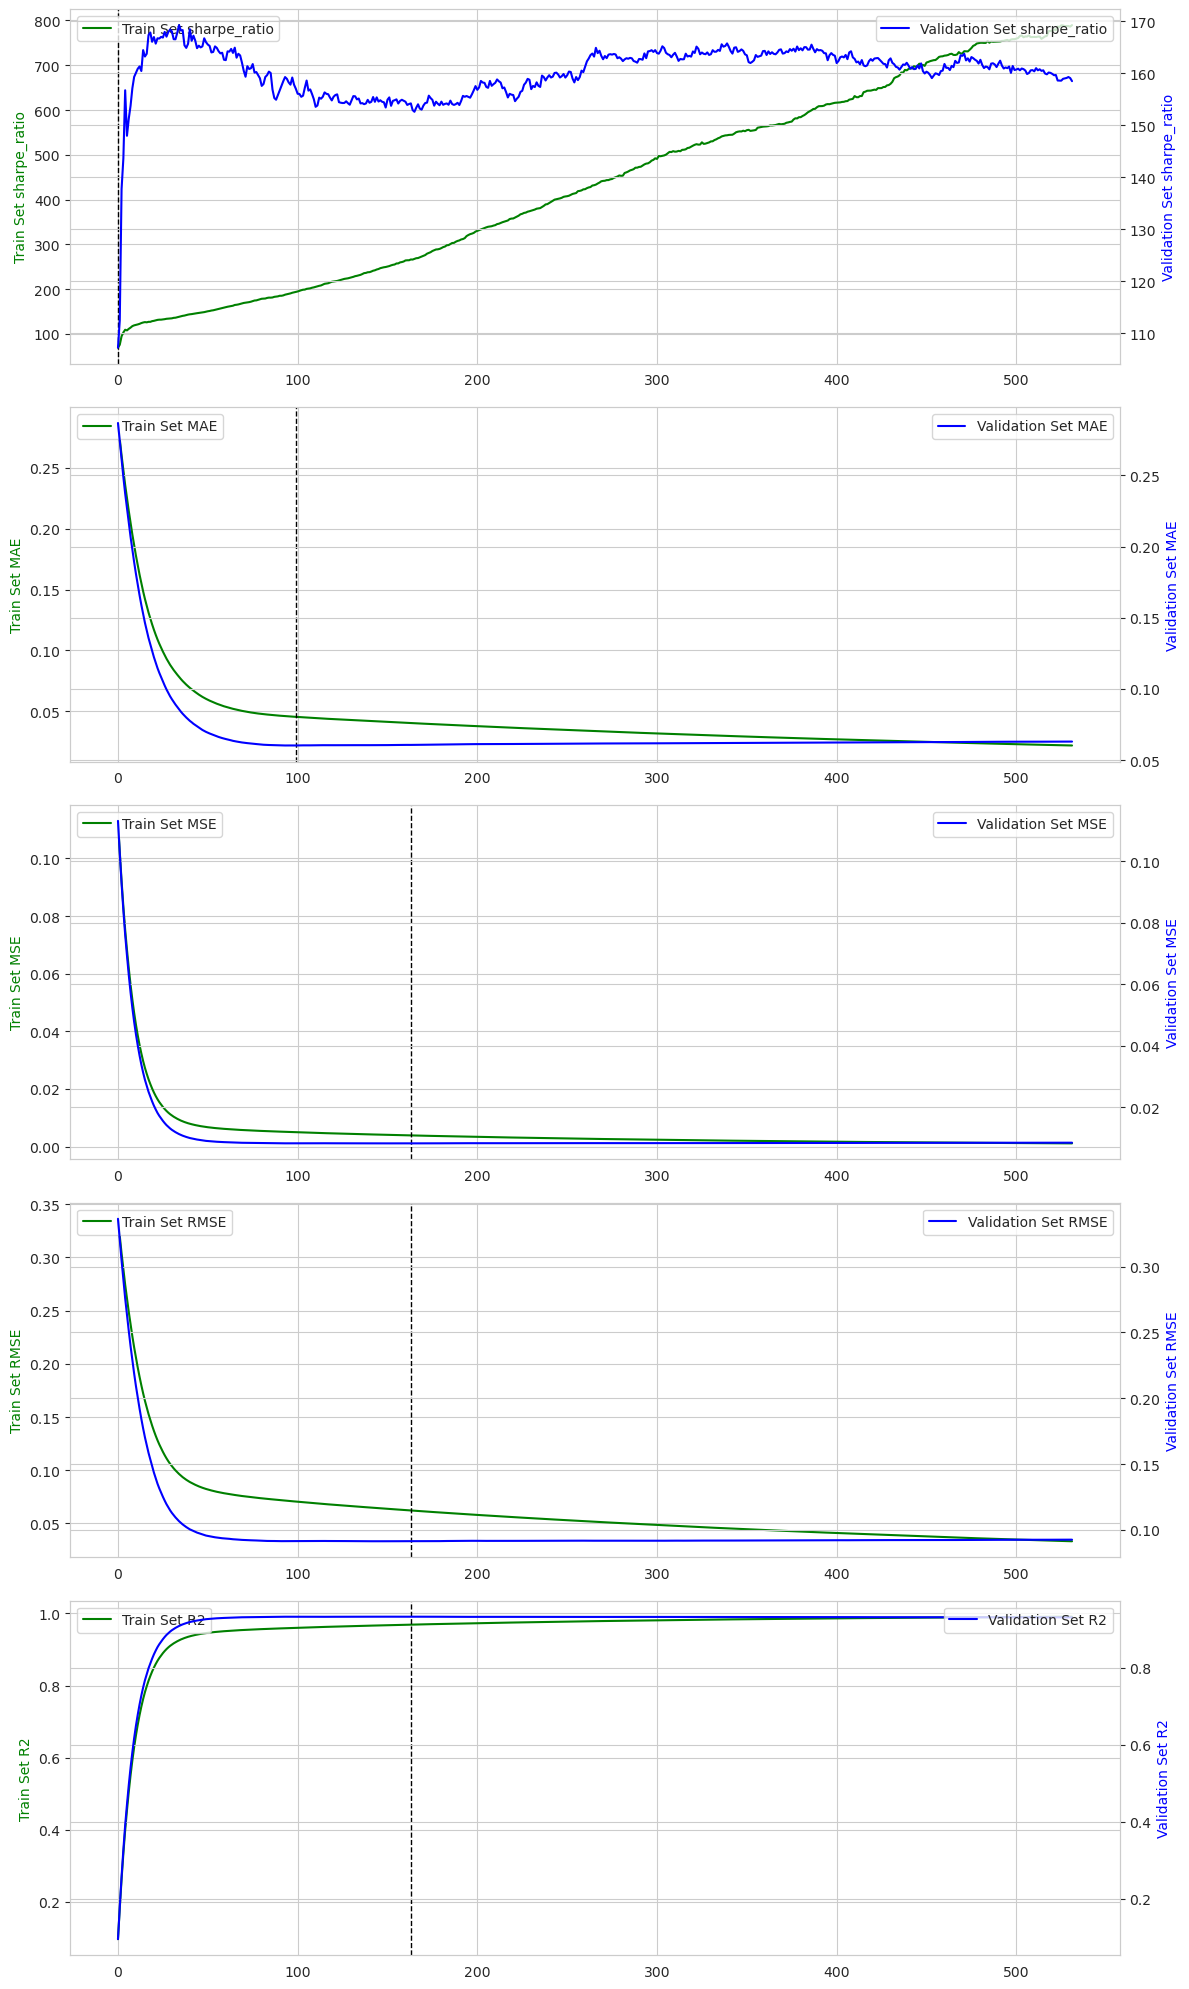

In [10]:
# Assuming evals_result contains MAE, MSE, RMSE, R2 as well
metrics = ['sharpe_ratio', 'MAE', 'MSE', 'RMSE', 'R2']

fig, axes = plt.subplots(len(metrics), 1, figsize=(12, 4 * len(metrics)))

for ax, metric in zip(axes, metrics):
    cv_result = pd.DataFrame({'Train Set': evals_result['train'][metric], 
                              'Validation Set': evals_result['valid_0'][metric]})
    
    ax1 = ax
    ax2 = ax1.twinx()  # instantiate a second axes sharing the same x-axis
    
    ax1.plot(cv_result.index, cv_result['Train Set'], 'g-', label=f'Train Set {metric}')
    ax2.plot(cv_result.index, cv_result['Validation Set'], 'b-', label=f'Validation Set {metric}')
    
    ax1.set_ylabel(f'Train Set {metric}', color='g')
    ax2.set_ylabel(f'Validation Set {metric}', color='b')
    
    if metric != 'R2':
        ax1.axvline(cv_result['Validation Set'].idxmin(), c='k', ls='--', lw=1)
    else:
        ax1.axvline(cv_result['Validation Set'].idxmax(), c='k', ls='--', lw=1)

    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()


In [11]:
# # Extract cat_threshold from best_params
# cat_threshold = best_params.get('cat_threshold', 50)  # default to 50 if not in best_params

# Extract cat_threshold from best_params
cat_threshold = best_params.pop('cat_threshold', 50)  # default to 50 if not in best_params


# Determine the categorical columns based on cat_threshold
categoricals = [col for col in dataset.columns if dataset[col].nunique() < cat_threshold 
                and dataset[col].ge(0).all() and col.startswith("FEATURE_")]

# Create the training dataset
lgb_train_all = lgb.Dataset(data=dataset[features], label=dataset[label], 
                            categorical_feature=categoricals, free_raw_data=False)

best_params['force_col_wise'] = True
# Get the best iteration from your previous training
# Get the best iteration from your previous training
optimal_boosting_rounds = evals_result['valid_0']['sharpe_ratio'].index(max(evals_result['valid_0']['sharpe_ratio']))

if optimal_boosting_rounds == 0:
    optimal_boosting_rounds = 1
    print(optimal_boosting_rounds)

best_model = lgb.train(params=best_params,
                       train_set=lgb_train_all,
                       num_boost_round=optimal_boosting_rounds,  # Use the optimal number of rounds
                       feval=combined_eval_metrics,  # Updated feval
                       callbacks=[lgb.record_evaluation(evals_result)])

[LightGBM] [Info] Total Bins 96007
[LightGBM] [Info] Number of data points in the train set: 117250, number of used features: 538
[LightGBM] [Info] Start training from score 0.501501


In [12]:
from pathlib import Path

# Define the models folder path
models = Path("./models")

# Ensure the folder exists
models.mkdir(exist_ok=True)

# Ensure that dataset_key doesn't contain invalid characters like slashes
clean_dataset_key = dataset_key.replace("/", "_")

# Formulate the clean save path
save_path = models / f"{top}{clean_dataset_key}_best_model_{target}.txt"

# Try saving again
best_model.save_model(save_path)
print(f"Model saved to {save_path}")

Model saved to models/250_data_YEAR_20200930_20220802_best_model_TARGET_ret_fwd_frac_order.txt


#### Test on unseen data

In [13]:
from pathlib import Path
import pandas as pd
from utils import rank_stocks_and_quantile

top = 250  # parameters -> papermill
UNSEEN_KEY = '/data/YEAR_20220803_20230803'
UNSEEN_STORE = Path(f'data/{top}_unseen_dataset.h5')
with pd.HDFStore(UNSEEN_STORE) as store:
    test_data = store[UNSEEN_KEY]
    test_data = rank_stocks_and_quantile(test_data, TARGET_col=target)
    # print(store.keys())

In [14]:
test_features = test_data[features]
test_labels = test_data[label]

model_path = f"/home/sayem/Desktop/Project/{save_path}"
# Load the model
best_model = lgb.Booster(model_file=model_path)

y_pred = best_model.predict(test_features)

preds = test_labels.reset_index(name=\
    'actual').assign(predicted=y_pred).set_index(['date', 'ticker'])

# Rename columns to add 'feature_' prefix
cols_to_rename = ['open', 'high', 'low', 'close', 'volume']
new_col_names = ["FEATURE_" + col for col in cols_to_rename]
rename_dict = dict(zip(cols_to_rename, new_col_names))

test_data_renamed = test_data.rename(columns=rename_dict)

# Using the 'merge' method to join on MultiIndex levels 'date' and 'ticker'
preds = preds.reset_index().merge(test_data_renamed[new_col_names].reset_index(), 
                                  on=['ticker', 'date'], 
                                  how='left')

### Only select columns of interest
preds = preds[['date', 'ticker', 'actual', 'predicted'] \
    + new_col_names].set_index(['ticker', 'date'])


In [15]:
preds.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 66002 entries, ('AA', Timestamp('2022-08-03 00:00:00+0000', tz='UTC')) to ('ZTS', Timestamp('2023-08-03 00:00:00+0000', tz='UTC'))
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   actual          66002 non-null  float64
 1   predicted       66002 non-null  float64
 2   FEATURE_open    66002 non-null  float32
 3   FEATURE_high    66002 non-null  float32
 4   FEATURE_low     66002 non-null  float32
 5   FEATURE_close   66002 non-null  float32
 6   FEATURE_volume  66002 non-null  float64
dtypes: float32(4), float64(3)
memory usage: 2.8+ MB


Dropped 52.8% entries from factor data: 4.0% in forward returns computation and 48.8% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 60.0%, not exceeded: OK!

Sharpe Ratios:
 1D     0.862606
5D     0.390668
10D    0.295210
dtype: float64
Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1.0,0.00,0.25,0.019410,0.066906,6440,21.647059
2.0,0.25,0.50,0.344882,0.121324,8695,29.226891
3.0,0.50,0.75,0.566008,0.110219,3670,12.336134
4.0,0.75,0.75,0.750000,0.000000,5015,16.857143
5.0,1.00,1.00,1.000000,0.000000,5930,19.932773


Returns Analysis


,1D,5D,10D
Ann. alpha,0.931,0.130,0.073
beta,-0.073,-0.055,-0.078
Mean Period Wise Return Top Quantile (bps),27.702,5.495,3.283
Mean Period Wise Return Bottom Quantile (bps),-38.445,-6.722,-3.957
Mean Period Wise Spread (bps),66.147,12.241,7.271


<Figure size 640x480 with 0 Axes>

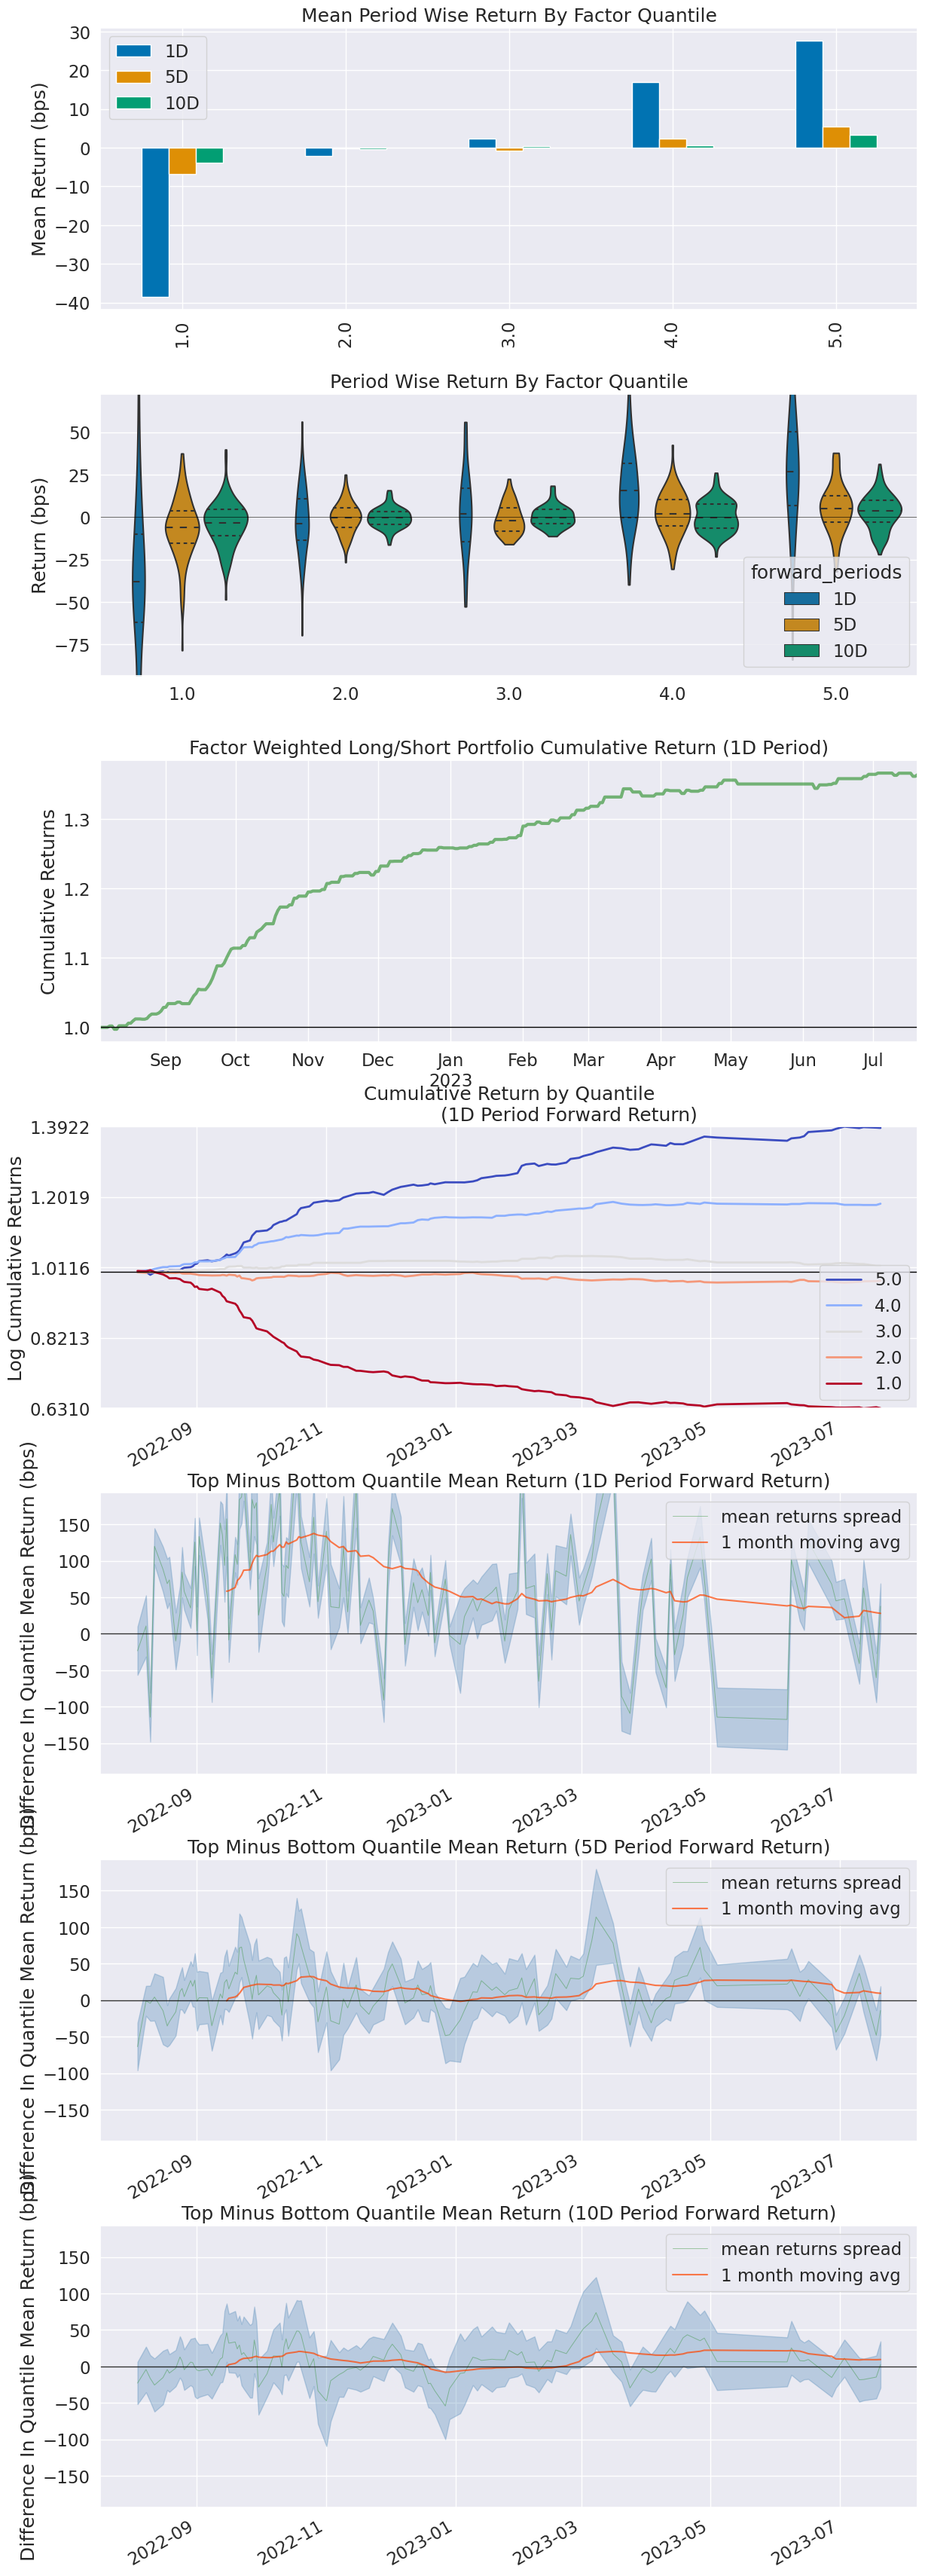

Information Analysis


,1D,5D,10D
IC Mean,0.125,0.048,0.039
IC Std.,0.148,0.126,0.128
Risk-Adjusted IC,0.850,0.382,0.302
t-stat(IC),NaN,NaN,NaN
p-value(IC),NaN,NaN,NaN
IC Skew,NaN,NaN,NaN
IC Kurtosis,NaN,NaN,NaN


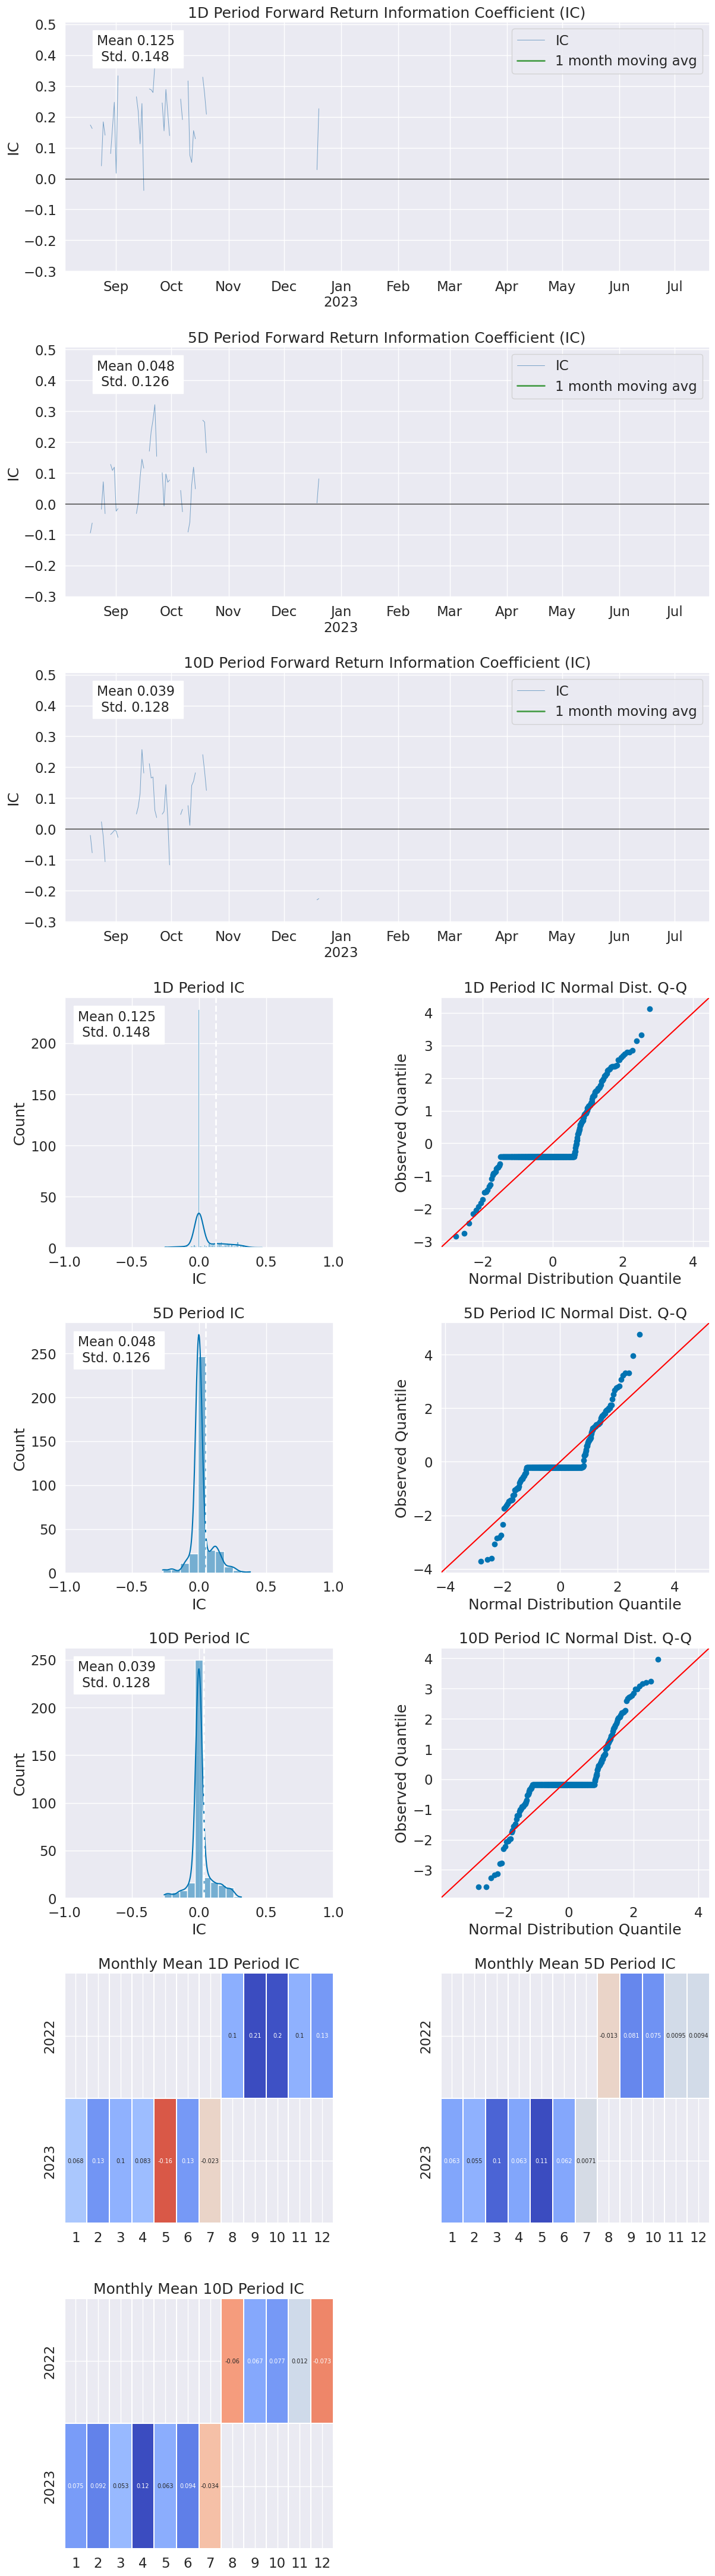

Turnover Analysis


,1D,5D,10D
Quantile 1.0 Mean Turnover,0.176,0.207,0.239
Quantile 2.0 Mean Turnover,0.333,0.436,0.330
Quantile 3.0 Mean Turnover,0.364,0.465,0.477
Quantile 4.0 Mean Turnover,0.297,0.337,0.371
Quantile 5.0 Mean Turnover,0.120,0.149,0.161


,1D,5D,10D
Mean Factor Rank Autocorrelation,0.917,0.89,0.884


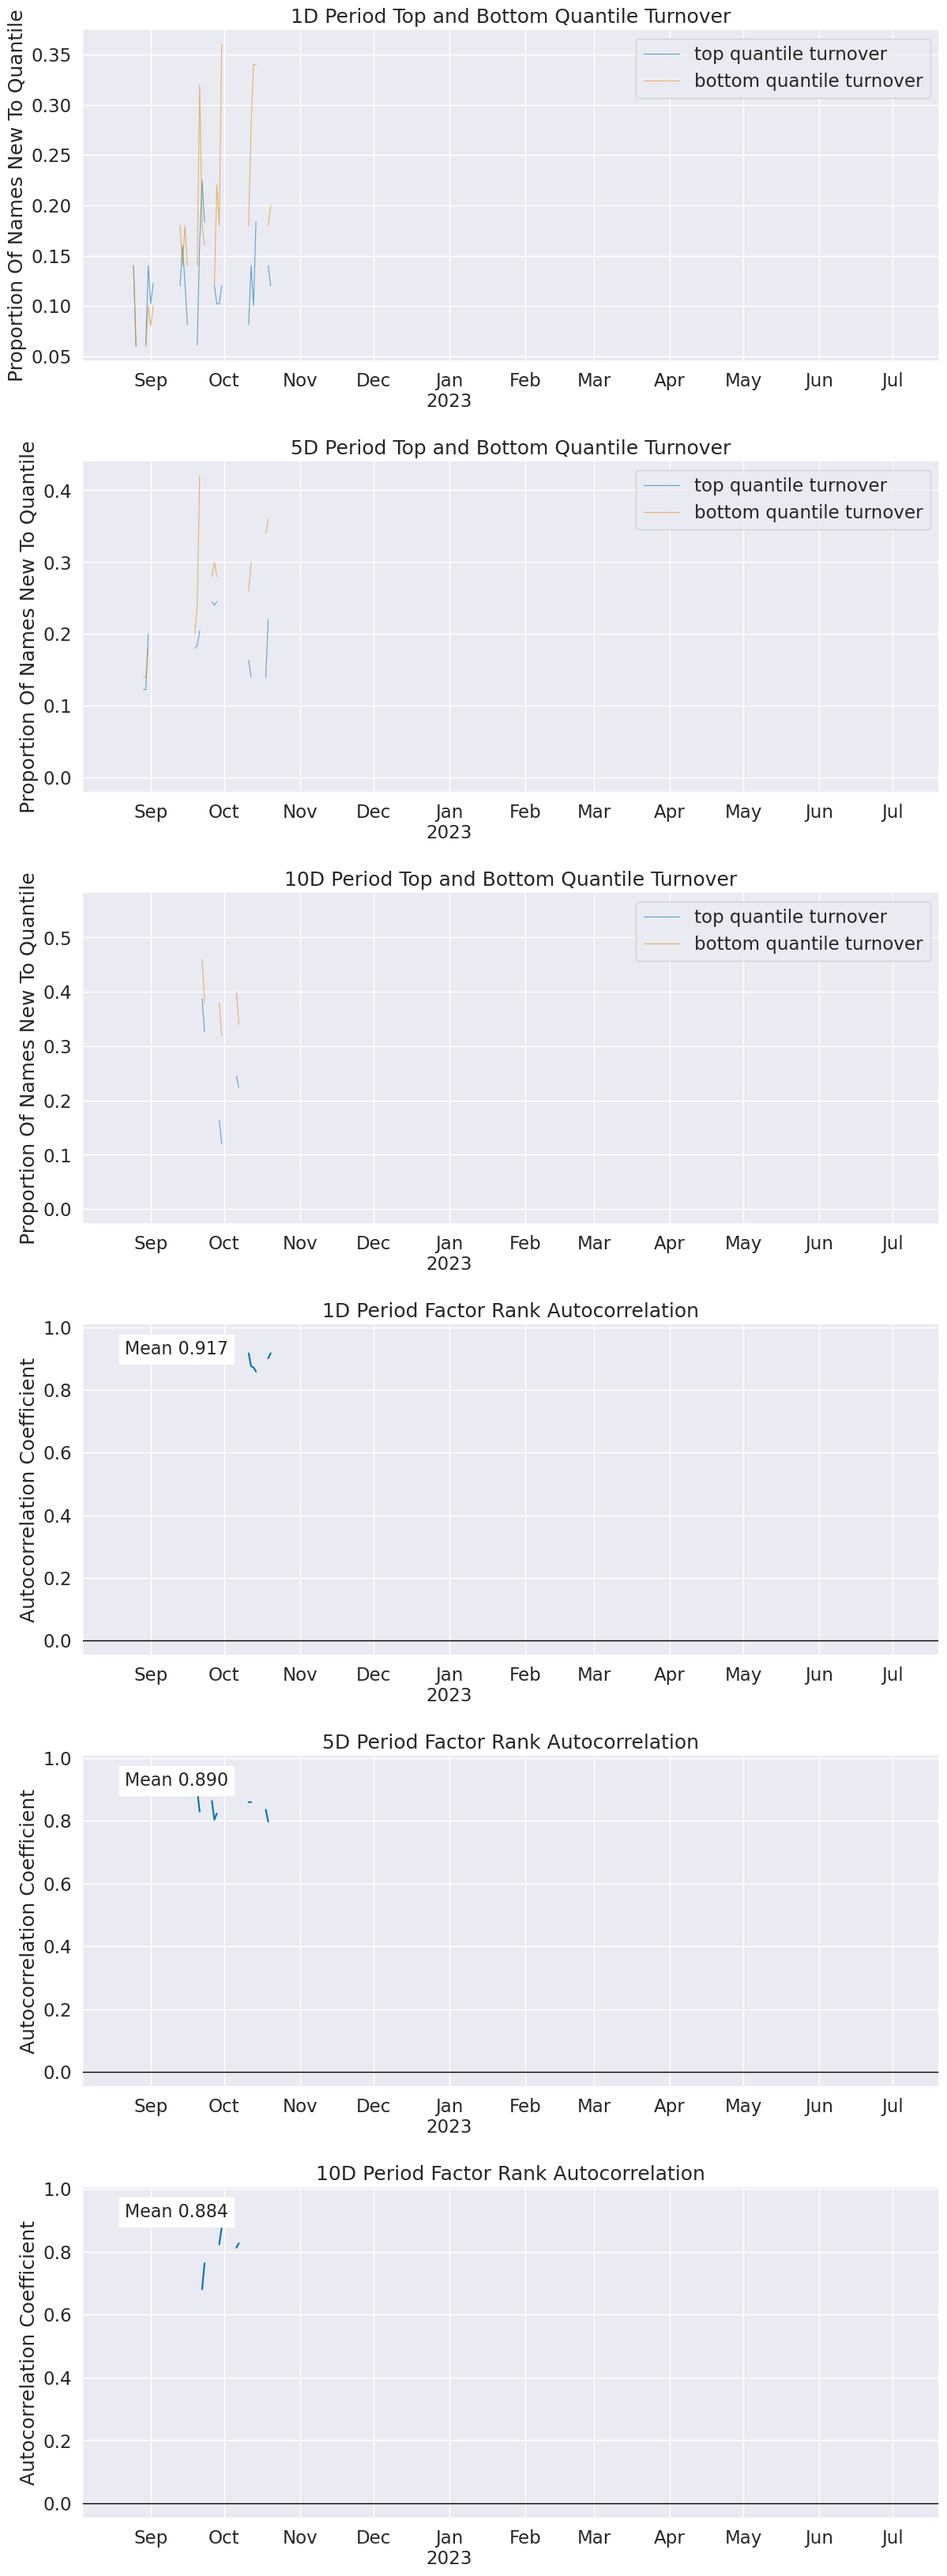

In [16]:
import pandas as pd
import alphalens as al

def generate_alphalens_tearsheet(df: pd.DataFrame, label_col: str, price_col: str) -> None:
    """
    Generate the Alphalens full tearsheet given the input dataframe, 
    label column, and price data column.
    """
    # Extract the factor and trade_prices series
    factor = df[label_col]
    trade_prices = df[price_col]
    
    # Remove duplicated indices from factor and trade_prices
    factor = factor[~factor.index.duplicated(keep='first')]
    trade_prices = trade_prices[~trade_prices.index.duplicated(keep='first')]
    
    # Convert the trade_prices series into unstacked format
    trade_prices_unstacked = trade_prices.unstack(level='ticker')
    
    # Ensure the factor's DatetimeIndex level has the same timezone as trade_prices_unstacked
    if isinstance(factor.index, pd.MultiIndex):
        level_0 = factor.index.get_level_values(0)
        if hasattr(level_0, 'tz') and level_0.tz is not None:
            if level_0.tz != trade_prices_unstacked.index.tz:
                factor.index.set_levels(level_0.tz_convert(trade_prices_unstacked.index.tz), \
                    level=0, inplace=True)
        factor = factor.swaplevel().sort_index()
    else:
        if hasattr(factor.index, 'tz') and factor.index.tz is not None:
            if factor.index.tz != trade_prices_unstacked.index.tz:
                factor.index = factor.index.tz_convert(trade_prices_unstacked.index.tz)

    # Create the factor_data dataframe with forward returns
    alphalen_analysis = al.utils.get_clean_factor_and_forward_returns(
        factor=factor,
        prices=trade_prices_unstacked,
        periods=[1, 5, 10],
        max_loss=0.6
    )

    factor_returns = al.performance.factor_returns(alphalen_analysis)
    sharpe_ratios = factor_returns.mean() / factor_returns.std()

    print("\nSharpe Ratios:\n", sharpe_ratios)
    alphalen_analysis = alphalen_analysis[~alphalen_analysis.index.duplicated(keep='first')]
    alphalen_analysis = alphalen_analysis.groupby(level=[0, 1]).mean()
    return alphalen_analysis

target = 'actual'
alphalens_analysis = generate_alphalens_tearsheet(preds, \
    label_col=target, price_col='FEATURE_close')

import alphalens as al
al.tears.create_full_tear_sheet(alphalens_analysis)

In [17]:
# import pandas as pd
# import alphalens as al

# def generate_alphalens_tearsheet(df: pd.DataFrame, \
#     label_col: str, price_col: str) -> None:
#     """
#     Generate the Alphalens full tearsheet given the input dataframe, 
#     label column, and price data column.
#     """
#     # Extract the factor and trade_prices series
#     factor = df[label_col]
#     trade_prices = df[price_col]
    
#     # Handle duplicate indices in trade_prices
#     trade_prices = trade_prices[~trade_prices.index.duplicated(keep='first')]
    
#     # Convert the trade_prices series into unstacked format
#     trade_prices_unstacked = trade_prices.unstack(level='ticker')
    
#     # Ensure the factor's DatetimeIndex level has the same timezone as trade_prices_unstacked
#     if isinstance(factor.index, pd.MultiIndex):
#         level_0 = factor.index.get_level_values(0)
#         if hasattr(level_0, 'tz') and level_0.tz is not None:
#             if level_0.tz != trade_prices_unstacked.index.tz:
#                 factor.index.set_levels(level_0.tz_convert(trade_prices_unstacked.index.tz), level=0, inplace=True)
#         factor = factor.swaplevel().sort_index()
#     else:
#         if hasattr(factor.index, 'tz') and factor.index.tz is not None:
#             if factor.index.tz != trade_prices_unstacked.index.tz:
#                 factor.index = factor.index.tz_convert(trade_prices_unstacked.index.tz)

#     # Create the factor_data dataframe with forward returns
#     alphalen_analysis = al.utils.get_clean_factor_and_forward_returns(
#         factor=factor,
#         prices=trade_prices_unstacked,
#         periods=[1, 5, 10],
#         max_loss=0.5
#     )

#     factor_returns = al.performance.factor_returns(alphalen_analysis)
#     sharpe_ratios = factor_returns.mean() / factor_returns.std()

#     print("\nSharpe Ratios:\n", sharpe_ratios)
#     alphalen_analysis = alphalen_analysis[~alphalen_analysis.index.duplicated(keep='first')]
#     alphalen_analysis = alphalen_analysis.groupby(level=[0, 1]).mean()
#     return alphalen_analysis

# target = 'predicted'
# alphalens_analysis = generate_alphalens_tearsheet(preds, label_col=target, price_col='FEATURE_close')

# import alphalens as al
# al.tears.create_full_tear_sheet(alphalens_analysis)

In [18]:
preds

,,actual,predicted,FEATURE_open,FEATURE_high,FEATURE_low,FEATURE_close,FEATURE_volume
ticker,date,,,,,,,
AA,2022-08-03 00:00:00+00:00,0.25,0.361512,48.448700,48.631500,47.298901,48.269600,4.403141e+06
AAL,2022-08-03 00:00:00+00:00,0.00,0.077930,14.200000,14.700000,14.150000,14.630000,2.836655e+07
AAPL,2022-08-03 00:00:00+00:00,0.75,0.730800,160.350998,166.082993,160.261002,165.625000,8.275915e+07
ABBV,2022-08-03 00:00:00+00:00,0.25,0.442552,140.292007,141.578995,139.227997,139.778000,5.529937e+06
ABT,2022-08-03 00:00:00+00:00,0.50,0.364608,108.598000,109.454002,107.762001,109.095001,3.884412e+06
...,...,...,...,...,...,...,...,...
WYNN,2023-08-03 00:00:00+00:00,0.75,0.651560,104.250000,106.849998,102.129997,105.610001,1.614293e+06
X,2023-08-03 00:00:00+00:00,0.25,0.138212,24.360001,24.865000,23.750000,24.260000,9.083687e+06
XOM,2023-08-03 00:00:00+00:00,0.50,0.473597,105.889999,107.879997,105.300003,107.120003,1.628311e+07


In [19]:
def daily_spearman(group):
    return spearmanr(group['actual'], group['predicted'])[0]

daily_correlations = preds.groupby('date').apply(daily_spearman)

In [20]:
daily_correlations

date
2022-08-03 00:00:00+00:00    0.952475
2022-08-04 00:00:00+00:00    0.959541
2022-08-05 00:00:00+00:00    0.961014
2022-08-08 00:00:00+00:00    0.950994
2022-08-09 00:00:00+00:00    0.964955
2022-08-10 00:00:00+00:00    0.963558
2022-08-11 00:00:00+00:00    0.964465
2022-08-12 00:00:00+00:00    0.966687
2022-08-15 00:00:00+00:00    0.969821
2022-08-16 00:00:00+00:00    0.965234
2022-08-17 00:00:00+00:00    0.965283
2022-08-18 00:00:00+00:00    0.950980
2022-08-19 00:00:00+00:00    0.940327
2022-08-22 00:00:00+00:00    0.953244
2022-08-23 00:00:00+00:00    0.961079
2022-08-24 00:00:00+00:00    0.954508
2022-08-25 00:00:00+00:00    0.913337
2022-08-26 00:00:00+00:00    0.947001
2022-08-29 00:00:00+00:00    0.944424
2022-08-30 00:00:00+00:00    0.944493
2022-08-31 00:00:00+00:00    0.928735
2022-09-01 00:00:00+00:00    0.939501
2022-09-02 00:00:00+00:00    0.928379
2022-09-06 00:00:00+00:00    0.959515
2022-09-07 00:00:00+00:00    0.960038
2022-09-08 00:00:00+00:00    0.964967
2022-09

In [21]:
daily_correlations.mean()

0.9370571112943491

In [22]:
daily_correlations.std()

0.022031503088906907

In [23]:
# Calculate the mean of daily correlations
mean_daily_correlation = daily_correlations.mean()

# Calculate Sharpe ratio for each date
fold_sharpe_ratio = papermill_fold_scores = daily_correlations / daily_correlations.std()

papermill_fold_scores_df = papermill_fold_scores.to_frame()
papermill_fold_scores_df.columns = papermill_fold_scores_df.columns.astype(str)
sb.glue("papermill_era_scores", papermill_fold_scores_df, display=True)

,0
date,
2022-08-03 00:00:00+00:00,43.232400
2022-08-04 00:00:00+00:00,43.553127
2022-08-05 00:00:00+00:00,43.619996
2022-08-08 00:00:00+00:00,43.165182
2022-08-09 00:00:00+00:00,43.798857
2022-08-10 00:00:00+00:00,43.735475
2022-08-11 00:00:00+00:00,43.776634
2022-08-12 00:00:00+00:00,43.877483
2022-08-15 00:00:00+00:00,44.019721


In [24]:
# import matplotlib.pyplot as plt

# # Create a list of colors based on the sign of the Sharpe Ratios
# colors = ['blue' if value > 0 else 'red' for value in fold_sharpe_ratio]

# plt.figure(figsize=(12,6))
# fold_sharpe_ratio.plot(kind='bar', color=colors)
# plt.title('Daily Sharpe Ratios')
# plt.xlabel('Date')
# plt.ylabel('Sharpe Ratio')
# plt.grid(axis='y')
# plt.tight_layout()
# plt.axhline(y=0, color='black', linestyle='-')  # Here's where we add the horizontal line at y=0
# plt.xticks(rotation=45)  # rotates the x-axis labels for better visibility
# plt.show()

In [25]:
# plot_dir = Path("plots")
# plot_dir.mkdir(exist_ok=True)
# plot_path = plot_dir / f"sharpe_ratios_{key}.png"
# plt.savefig(plot_path)
# plt.close()

# papermill_plot_path_str = str(plot_path)  # Convert to string
# sb.glue("papermill_plot_path", papermill_plot_path_str, display=True)  # Glue the string

In [26]:
lr_r, lr_p = spearmanr(preds.actual, preds.predicted)
print(f'Information Coefficient (overall): {lr_r:.3%} (p-value: {lr_p:.8%})')

# Return the Information Coefficient and its p-value
information_coefficient = lr_r
p_value = lr_p

# information_coefficient = papermill_information_coefficient, p_value = papermill_p_value
sb.glue("information_coefficient", information_coefficient, display=True)
sb.glue("p_value", p_value, display=True)

Information Coefficient (overall): 93.144% (p-value: 0.00000000%)


0.9314373340148935

0.0

In [27]:
# papermill_plot_path_str = str(plot_path)  # Convert to string
# sb.glue("papermill_plot_path", papermill_plot_path_str)  # Glue the string

# sb.glue("information_coefficient", information_coefficient)
# sb.glue("p_value", p_value)